# Stroma Vision Machine Learning Engineer Technical Interview

**Çalışmanın amacı:** Video üzerinde düşen somun ile cıvataları yüksek doğrulukla ve hızla tespit etmek ve takip etmek.

İşaretlemelerimiz COCO veri kümesi formatında olduğu ve model olarak YOLO kullanacağımız için verileri uygun formata getirmeliyiz. 

Kullanacağımız veri kümesindeki dosya düzenimiz bu şekildedir:

```
dataset
├── labels
│   ├── train
│   ├── test
│   └── val
├── images
│   ├── train
│   ├── test
│   └── val
│
└── labels.txt
```

Faydalanılan kod: https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-json-to-yolo-txt/

Videoları karelere(framelere) ayırıp 0001.jpg - 0001.txt gibi etiketlemeye denk gelecek şekilde çıkarım yapılır.

In [2]:
import cv2
from tqdm import tqdm
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Dosya yolları
vid_paths = ["./challenge/images/train/train.mp4","./challenge/images/test/test.mp4","./challenge/images/val/val.mp4"]
out_paths = ["./dataset/images/train","./dataset/images/test","./dataset/images/val"]

def extract_vid2frame(video_path, output_path):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    out = "{output_path}/".format(output_path=output_path)
    while success:
        filename = "{count}".format(count=count)
        cv2.imwrite( out + filename.zfill(4) + ".jpg", image) #Dosya isimlerinin 4 basamaklı isimlendirilmesi(0010.jpg gibi)
        success,image = vidcap.read()
        count += 1
    print("Extraction finished. Output path: {output_path}".format(output_path=output_path))   
    
for i in range(3):
    extract_vid2frame(vid_paths[i],out_paths[i])

Extraction finished. Output path: ./dataset/images/train
Extraction finished. Output path: ./dataset/images/test
Extraction finished. Output path: ./dataset/images/val


Sonrasında json dosyasından her bir görüntü için txt dosyası olacak şekilde dönüşüm yapılır.

YOLO txt içeriği: `<object-class-id>` `<x>` `<y>` `<width>` `<height>`

In [7]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    
    # YOLO bounding box format: [x_center, y_center, width, height]

    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

YOLO modeli 0'dan başlamayan etiketlemeler için hata verebiliyor. Bu yüzden aşağıda etiket ismini ve sırasını değiştirmeden numaralandırmasını değiştiriyoruz.

In [8]:
def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)
     
    for image in tqdm(json_data["images"], desc="Annotation txt for each image"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = anno["category_id"] - 1 #Etiketler 1-2 yerine 0-1 olarak değiştiriliyor
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

In [9]:
input_labels = ["./challenge/annotations/instances_train.json",
                "./challenge/annotations/instances_test.json",
                "./challenge/annotations/instances_val.json"]
out_labels = ["./dataset/labels/train",
              "./dataset/labels/test",
              "./dataset/labels/val"]

for j in range(3):
    convert_coco_json_to_yolo_txt(out_labels[j],input_labels[j])

C:\Users\Asus\AppData\Local\Temp\ipykernel_8740\491188809.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image in tqdm(json_data["images"], desc="Annotation txt for each image"):


Annotation txt for each image:   0%|          | 0/7200 [00:00<?, ?it/s]

Converting COCO Json to YOLO txt finished!


Annotation txt for each image:   0%|          | 0/1800 [00:00<?, ?it/s]

Converting COCO Json to YOLO txt finished!


Annotation txt for each image:   0%|          | 0/1800 [00:00<?, ?it/s]

Converting COCO Json to YOLO txt finished!


## Preprocess işlemleri:

Bu bölümde verileri inceleyip iyileştirmeyi ve yapay zeka modeli için nesne tespitini kolaylaştırmayı hedefliyoruz.

In [8]:
#Görüntüleri incelemek için videodan çıkarılan sahnelerin dosya yolu veriliyor
path = 'C:\\Users\\Asus\\Desktop\\Stroma_Vision\\'
images = os.listdir(path + './dataset/images/train/')

In [36]:
images_list = []
#Sadece incelemek için ilk 500 görüntüyü alınıyor
for img in tqdm(images[0:500]):
    image = cv2.imread('./dataset/images/train/' + img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_list.append(image)

100%|██████████| 500/500 [00:02<00:00, 177.11it/s]


In [37]:
#Nesnelerin göründüğü bir sahne seçiliyor
preprocess_img = images_list[438].copy()

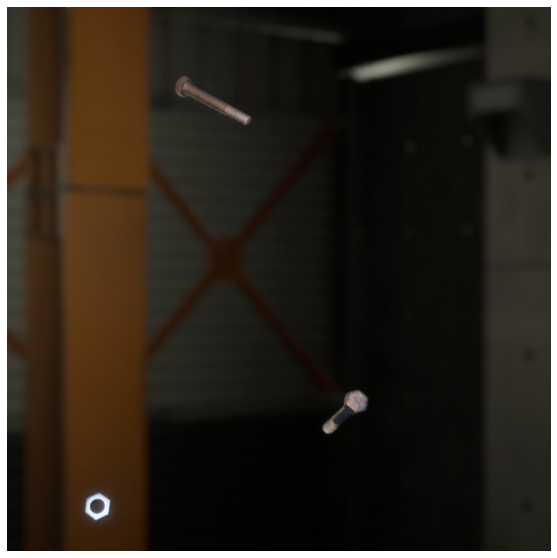

In [38]:
#Sahnenin görüntülenmesi
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(images_list[438])

(array([ 1.6536e+05,       47031,       57143,       63176,       39780,       32376,        1752,         560,         509,         399,         444,         453,         172,          51,          17,          28,          50,          68,         142,          90]),
 array([          0,        12.8,        25.6,        38.4,        51.2,          64,        76.8,        89.6,       102.4,       115.2,         128,       140.8,       153.6,       166.4,       179.2,         192,       204.8,       217.6,       230.4,       243.2,         256]),
 <BarContainer object of 20 artists>)

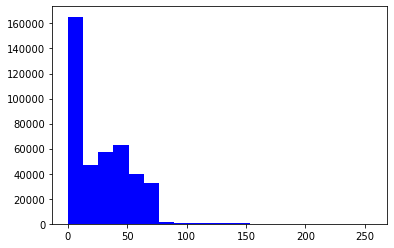

In [12]:
#RGB -> LAB renk aralığında dönüşüm yapılıyor
lab = cv2.cvtColor(preprocess_img.copy(), cv2.COLOR_RGB2LAB)
l,a,b = cv2.split(lab)
#L kanalı ile görüntünün sadece siyah-beyaz olan ve parlaklık değerlerini bulunduran katmanını alıyoruz
#Görüntünün histogram grafiğini yazdırıyoruz
plt.hist(l.flatten(),20,[0,256],color = "b")

Histogram grafiği çok düzensiz olduğu için histogram eşitleme için normal histogram eşitleme yöntemi yerine "Adaptif(Uyarlanabilir) Histogram Eşitleme - CLAHE" yöntemini kullanacağız. Bu yöntemde eşitleme görüntüde bölgesel olarak yapılıp daha iyi sonuçlar alınılabilir.

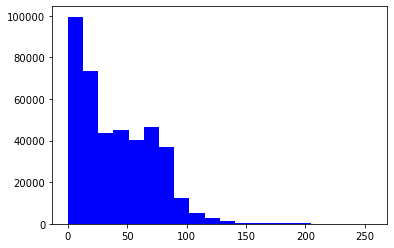

In [51]:
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))
clh_img = clahe.apply(l)
plt.hist(clh_img.flatten(),20,[0,256],color = "b")
plt.show()

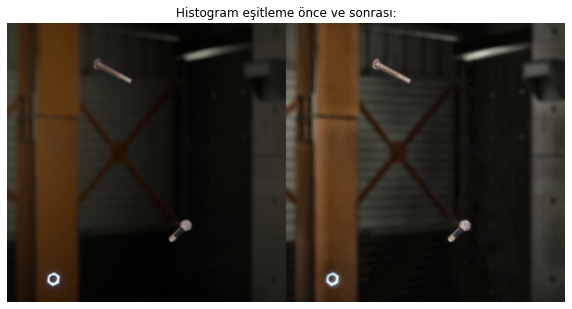

In [53]:
#L kanalı tekrar diğer kanallarla birleştiriliyor
equalized_img = cv2.merge((clh_img,a,b))
equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_LAB2RGB)
hist_imgs = np.hstack((preprocess_img,equalized_img))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title("Histogram eşitleme önce ve sonrası:")
plt.imshow(hist_imgs)

Threshold uygulayıp nesne kenarlarını çıkarmak için önce siyah-beyaza dönüşüm ve gauss bulanıklaştırması uygulanır.

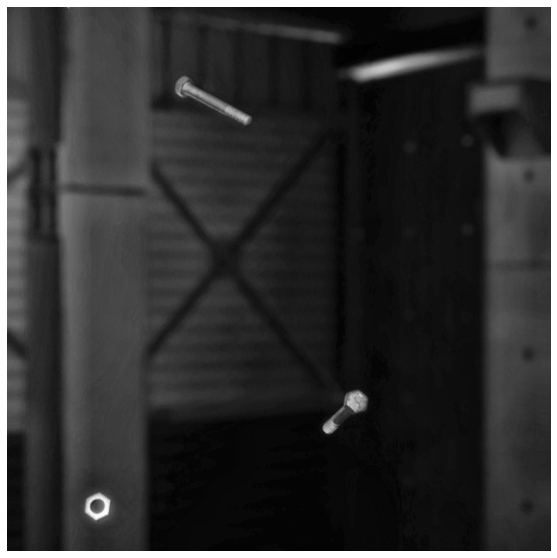

In [54]:
preprocess_img = cv2.cvtColor(equalized_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(preprocess_img, cmap='gray')

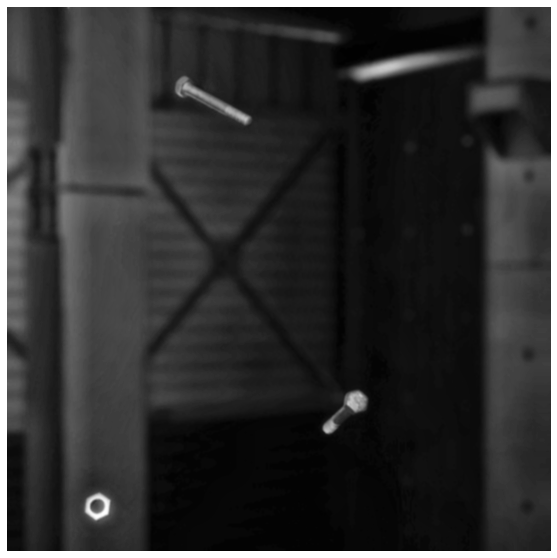

In [55]:
blur = cv2.GaussianBlur(preprocess_img,(3,3),0)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(blur, cmap='gray')

Threshold yöntemleri olarak "Binary Threshold", "Otsu Threshold" ve "Adaptive Threshold" denendi.

Diğer threshold yöntemlerine göre "Adaptive Threshold" değişen parlaklık değerlerine karşı daha iyi sonuç verdiği için bu yöntemi kullandık.

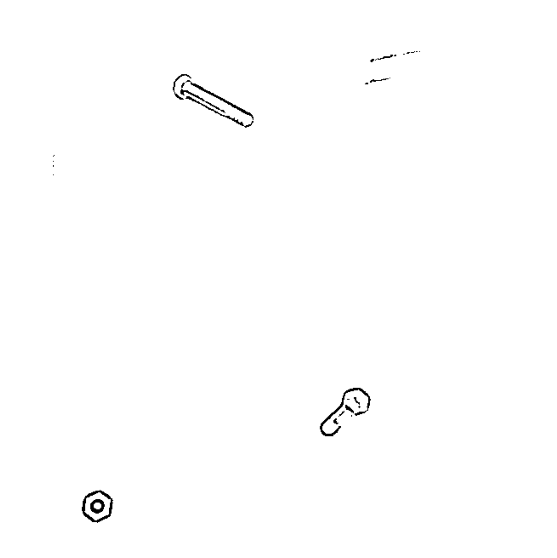

In [57]:
adaptive_th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,7)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(adaptive_th, cmap='gray')

Görüntüyü basitleştirip nesneleri tespit ettik. Threshold uygulanmamış görüntüler ile modelde eğitimi yapılıp başarı sonuçlarına göre seçim yapılabilir. 

Aşağıda kod ile görüntüler tümüne aynı işlemler uygulanabilir. folder değişkenine uygulanacak klasör yazılabilir. 

Not: İlerleyen eğitimlerde ön işleme aşaması ile daha düşük başarı sonucu verdiği için sadece histogram eşitleme aşamasını kullandık.

In [7]:
folder = "train"
path = 'C:\\Users\\Asus\\Desktop\\Stroma_Vision\\'
images = os.listdir(path + './dataset/images/{folder}/'.format(folder=folder))

for img in tqdm(images):
    image = cv2.imread('./dataset/images/{folder}/'.format(folder=folder) + img)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))
    clh_img = clahe.apply(l)
    equalized_img = cv2.merge((clh_img,a,b))
    equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_LAB2BGR)
    
    #preprocess_img = cv2.cvtColor(equalized_img, cv2.COLOR_RGB2GRAY)
    #blur = cv2.GaussianBlur(preprocess_img,(3,3),0)
    #adaptive_th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,11,7)
    cv2.imwrite('./dataset/images/{folder}/'.format(folder=folder) + img, equalized_img)

100%|██████████| 7200/7200 [02:16<00:00, 52.68it/s]


## Modelin Eklenmesi

### Yolov8 ile deneme:

Önce Yolov8 ile 10 epochluk eğitimde ön işlemeli ve normal görüntülerin başarısını karşılaştırıyoruz. (Burada Yolov8'i aynı zaman başarısını test etmek için ve hızlı eğittiği için kullandım ancak yeni bir versiyon olduğu ve onnx ile çalıştırma gibi bazı özellikleri desteklemediği için kullanmayacağız.)

In [1]:
import torch
print(torch.cuda.is_available())

True


Jupyter notebook'ta (başka yerel ortamlarda kullanılıyor olsa bile) Gpu algılanamayabilir. Eğer Gpu kullanılamıyorsa (False değeri aldıysanız) CUDA versiyonu ile uyumlu kütüphaneleri aşağıdakine benzer olacak şekilde indiriniz. Buradan da uyumlu versiyon bulunabilir: https://pytorch.org/get-started/previous-versions/

In [10]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

^C


In [ ]:
!pip install protobuf==3.20.1

In [1]:
from ultralytics import YOLO

Eğitim sırasında kernel kapanıyorsa aşağıdaki kod eklenebilir.

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Yolo modellerinde data klasörüne eğitim için custom.yaml dosyası ve train.py'ın bulunduğu klasöre hazırladığımız dataset klasörünü ekliyoruz.

Yolov8 için:
```
path: ../ultralytics/ultralytics/dataset/  
train: images/train
val: images/val
test: images/test

# Classes
names:
  0: bolt
  1: nut
```
Yolov7 için:
```
train: ./yolov7/dataset/images/train
val: ./yolov7/dataset/images/val
test: ./yolov7/dataset/images/test

# number of classes
nc: 2

# class names
names: [ 'bolt', 'nut']
```

Eğitim için aşağıdaki kod açılıp dosya yolu düzenlenerek çalıştırılabilir.

```
model = YOLO('yolov8n.pt')
results = model.train(
   data="C:/Users/Asus/Desktop/Stroma_Vision/ultralytics/ultralytics/yolo/data/datasets/custom.yaml",
   imgsz=640,
   epochs=10,
   batch=2,
   name='custom_train'
)
#results = model.val()  # evaluate model performance on the validation set
model = YOLO("runs/detect/custom_train18/weights/best.pt")
model(source="C:/Users/Asus/Desktop/Stroma_Vision/challenge/images/val/val.mp4",show=True,imgsz=640) 
#success = model.export(format="onnx",opset=12)  # export the model to ONNX format
```

Ön işlemeli verilerle eğitim sonuçları daha düşük çıktığı için sadece histogramı düzenlenmiş veri kümesini kullanacağız.

### Yolov7 ile Eğitim: 

Yolov7 kendi versiyonları içerisinde genel olarak hız ve başarıda iyi bir model. Aynı zamanda Yolo modeli canlı işleme için tercih edilen modeller arasında.

Yukarıda bahsedildiği gibi önce custom.yaml ve dataset klasörünü ekliyoruz. yolov7/cfg/training/yolov7.yaml içerisinde nc değerini iki etiketimiz olduğu için nc: 2 yapıyoruz.

Modelin indirilmesi:

In [26]:
!git clone https://github.com/WongKinYiu/yolov7.git

fatal: destination path 'yolov7' already exists and is not an empty directory.


Eğitimi parametleri ayarlayıp başlatıyoruz. --image-weights parametresini dengesiz etiket dağılımı için ekliyoruz.
Aynı zamanda yolov7/data/hyp.scratch.custom.yaml içerisinde uygulanacak veri arttırma yöntemleri de bulunmakta.

In [5]:
!python yolov7/train.py --device 0 --batch-size 2 --data yolov7/data/custom.yaml --img 640 640 --cfg yolov7/cfg/training/yolov7.yaml --weights 'yolov7/yolov7.pt' --name custom_train --hyp yolov7/data/hyp.scratch.custom.yaml --epochs 30 --image-weights

^C


In [ ]:
Elde ettiğimiz ağırlığı export.py ile onnx ve TensorRT kullanarak hızlandıracağız.

In [34]:
!pip install onnx_graphsurgeon

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     --------------------------------------- 40.9/40.9 kB 50.4 kB/s eta 0:00:00


In [37]:
!pip install coremltools==4.1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ------------------------------------- 882.2/882.2 kB 21.0 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Created wheel for coremltools: filename=coremltools-6.1-py3-none-any.whl size=1181375 sha256=d99047fd37edb36bd67ff495f965e2d52f9a772611b35899aa98746162e2b711
  Stored in directory: C:\Users\Asus\AppData\Local\Temp\pip-ephem-wheel-cache-pn0qglgb\wheels\f5\9a\5b\209716cf6c2a3e3708289ad5697fdf8316b085655012f391ae
Successfully built coremltools


In [39]:
!python yolov7/export.py --weights ./runs/train/custom_train/weights/best.pt --dynamic 

Namespace(weights='./runs/train/custom_train/weights/best.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=True, max_wh=None, topk_all=100, iou_thres=0.45, conf_thres=0.25, device='cpu', simplify=True, include_nms=False, fp16=False, int8=False)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
YOLOR  v0.1-121-g2fdc7f1 torch 1.8.1+cu111 CPU

Model Summary: 314 layers, 36487166 parameters, 6194944 gradients, 103.2 GFLOPS
C:\Users\Asus\Desktop\Stroma_Vision\yolov7\models\yolo.py:150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:
XGBoost version 1.7.2 has not been tested with coremltools. You may run into unexpected errors. XGBoost 1.4.2 is the most recent version that has been tested.
C:\Users\Asus\Desktop\Stroma_Vision\yolov7\models\yolo.py:150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be i


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse

Starting TorchScript export with torch 1.8.1+cu111...
TorchScript export success, saved as ./runs/train/custom_train/weights/best.torchscript.pt
CoreML export failure: No module named 'coremltools.libmilstoragepython'

Starting TorchScript-Lite export with torch 1.8.1+cu111...
TorchScript-Lite export success, saved as ./runs/train/custom_train/weights/best.torchscript.ptl

Starting ONNX export with onnx 1.10.2...

Starting export end2end onnx model for TensorRT...

Starting to simplify ONNX...
ONNX export success, saved as ./runs/train/custom_train/weights/best.onnx

Export complete (117.71s). Visualize with https://github.com/lutzroeder/netron.


In [41]:
!python yolov7/detect.py --weights ./runs/train/custom_train/weights/best.onnx --source ./challenge/images/val/val.mp4 --conf-thres 0.90 --iou-thres 0.70 --view-img --device 0 --img 640

Namespace(weights=['./runs/train/custom_train/weights/best.onnx'], source='./challenge/images/val/val.mp4', img_size=640, conf_thres=0.9, iou_thres=0.7, device='0', view_img=True, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
YOLOR  v0.1-121-g2fdc7f1 torch 1.8.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4095.5MB)

Traceback (most recent call last):
  File "C:\Users\Asus\Desktop\Stroma_Vision\yolov7\detect.py", line 196, in <module>
    detect()
  File "C:\Users\Asus\Desktop\Stroma_Vision\yolov7\detect.py", line 34, in detect
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "C:\Users\Asus\Desktop\Stroma_Vision\yolov7\models\experimental.py", line 252, in attempt_load
    ckpt = torch.load(w, map_location=map_location)  # load
  File "C:\Users\Asus\anaconda3\lib\site-packages\torch\serialization.py", line 593, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "C:\Users\Asus\anaconda3\lib\site-packages\torch\serialization.py", line 

In [ ]:
!python yolov7/export.py --weights ./runs/train/custom_train/weights/best.pt --grid --end2end --simplify --img-size 640 640 --dynamic